# Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

# Image Pipeline

Import the python file containing object tracking pipeline. This file contains all of the classes and helper functions. All parameter choices are made in this document.

In [1]:
%run car_tracking.py

In [2]:
%matplotlib inline

## The Car Classifier

The first step in the pipeline is to train a car classifier that is then used to identify cars in the subsequent sliding window search.

The feature set for the classifier consists of a histogram of oriented gradients (HOG), which essentially describes the shape of an image in a reduced feature space, by extracting the dominant gradient direction in so-called pixel cells which subdivide the image. In addition to the gradients, eac cell's color histogram is also recorded and used as a training feature.

### Histogram of Oriented Gradients (HOG)

The HOG is extracted from the lightness channel within the ImageFrame object which is in the HLS colour space. This ImageFrame object contains all of the information related to the current image or video frame of interest, including the HOG features and cell color histograms.

To improve the performance of the sliding window search, the HOG features are extracted once and then used for all queries. The size of the cell is already defined above.

In [3]:
cell_size = 8 #px
hog_params = {'orientations': 9,
              'pix_per_cell': cell_size,
              'cell_per_block': 2,
              'visualise': True}
histogram_bins = 32
colorspace = 'YCrCb'
spatial_size = (32, 32)

analyser = ImageAnalyser(hog_params, spatial_size=spatial_size, histogram_bins=histogram_bins, colorspace=colorspace)

When the image frame object is fed with an image, it automatically converts the image to the HLS colour space (from RGB) and computes the HOG features: 

In [4]:
preview = import_image('./test_images/image0120.png')
analyser(preview)

Visualise the result of the HOG feature extraction:

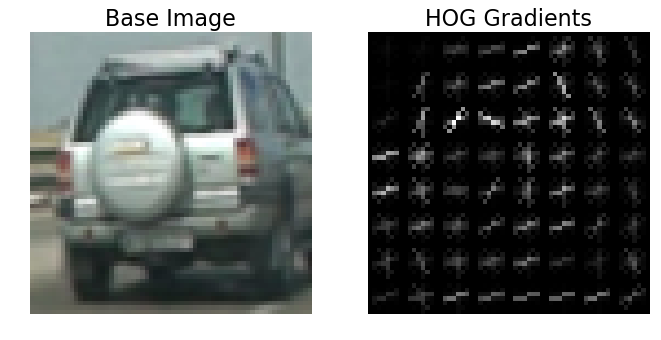

In [5]:
base_image = analyser.get_image()

compare_images(base_image, analyser.get_hog_visualisation(), ('Base Image', 'HOG Gradients'))

### Spatial Colour Bins and Histograms

For the colour features, the image is resized to a coarse representation and then each pixel channel is split into bins.

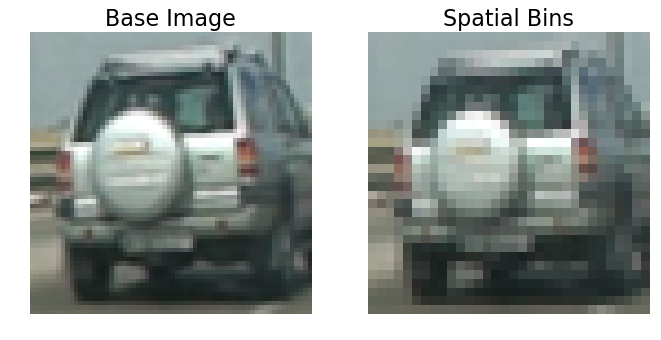

In [6]:
compare_images(base_image, analyser.get_spatial_visualisation(), ('Base Image', 'Spatial Bins'))

Finally, the histograms for each channel of the image are also recorded as features:

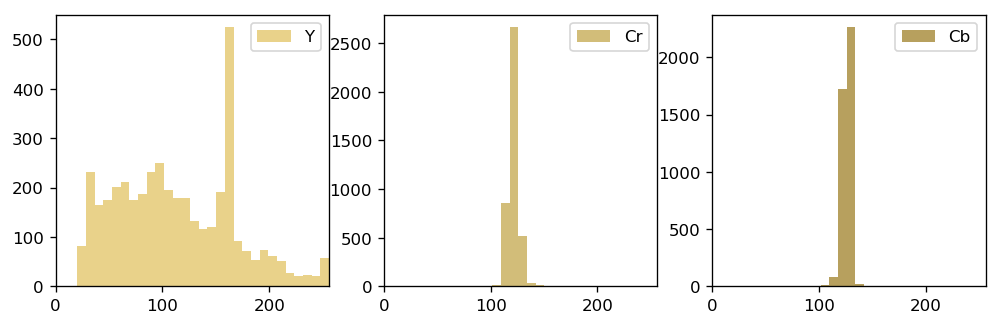

In [7]:
analyser.get_histogram_visualisation()

### Training the Classifier

Import the training data.

In [8]:
training_set = TrainingData('./training_data/')

Training data set imported.


A sample of the training images labeled as vehicles:

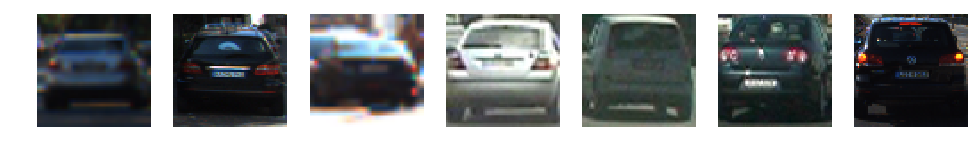

In [9]:
plt.subplots(1, 7, figsize=(12, 5), dpi=100)
for i, image in enumerate(training_set.get_random_training_images(label='vehicles', number=7)):
    plt.subplot(1, 7, i+1)
    plot_image(image)

A sample of the training images labeled as non-vehicles:

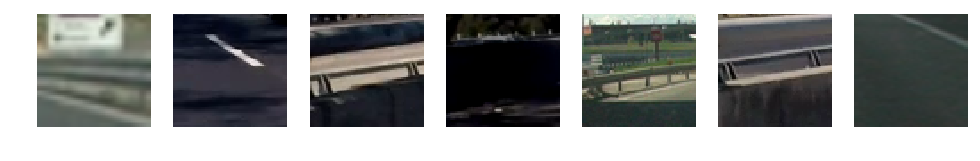

In [10]:
plt.subplots(1, 7, figsize=(12, 5), dpi=100)
for i, image in enumerate(training_set.get_random_training_images(label='non-vehicles', number=7)):
    plt.subplot(1, 7, i+1)
    plot_image(image)

Extract the desired training features from the data set. For this, the training set object makes use of an ImageFrame object to extract the features as seen above.

In [11]:
analyser = ImageAnalyser(hog_params, spatial_size=(32, 32), histogram_bins=32, colorspace='YCrCb')

In [12]:
training_set.extract_features(analyser)

Extracted feature vectors from images labelled as non-vehicles in 121.39029312133789 sec.
Extracted feature vectors from images labelled as vehicles in 118.40788626670837 sec.


Get training and test set:

In [13]:
(features_train, features_test, labels_train, labels_test) = training_set.get_data()

Set up a support vector machine classifier:

In [14]:
classifier = Classifier.svm_linear()

Normalising the features for fitting and inference:

In [15]:
classifier.fit_feature_scaler(features_train)

Fit the classifier to the training data:

In [16]:
classifier.train(features_train, labels_train, features_test, labels_test)

Classifier test accuracy =  0.98 (took 0.25 seconds on 4440 entries)


The accuracy of the classifier looks promising, so it should be suitable to identify cars for object tracking in the video frames.

Discussion on what I found during training:

## Sliding Window Search

Set the sliding window parameters and the portions of the area of interest where the sliding window search should be conducted for each respective window size. The units for the search windows are in pixels.

By inspection of the video resolution, it is found that cars smaller than 32x32px (8x8 cells) would be so far away that they are no longer of interest (and also too badly resolved to identify easily). Similarly, cars that are larger than 256x256px (32x32 cells) are extremely close and will likely be identified easily even with partial coverage. Two additional search window sizes are used between these two extremes to cover the full spectrum adequately.

In [182]:
search_windows = {'farthest': {'size': (6, 6),
                               'step_x': 2,
                               'step_y': 2,
                               'search_area': 'farthest'},
                  'far':      {'size': (8, 8),
                               'step_x': 3,
                               'step_y': 2,
                               'search_area': 'far'},
                  'near':     {'size': (12, 12),
                               'step_x': 6,
                               'step_y': 3,
                               'search_area': 'near'},
                  'nearest':  {'size': (24, 24),
                               'step_x': 8,
                               'step_y': 4,
                               'search_area': 'nearest'}}

Define the previously mentioned search areas as rectangles covering the area of interest.  The coordinates are given as fractions relative to the bounding box of the area of interest:

In [197]:
search_areas = {'nearest':  (( 0, 43), (160, 83)),
                'near':     (( 0, 48), (160, 68)),
                'far':      (( 1, 48), (159, 66)),
                'farthest': ((41, 49), (119, 63))}

Visualise the search areas in the image:

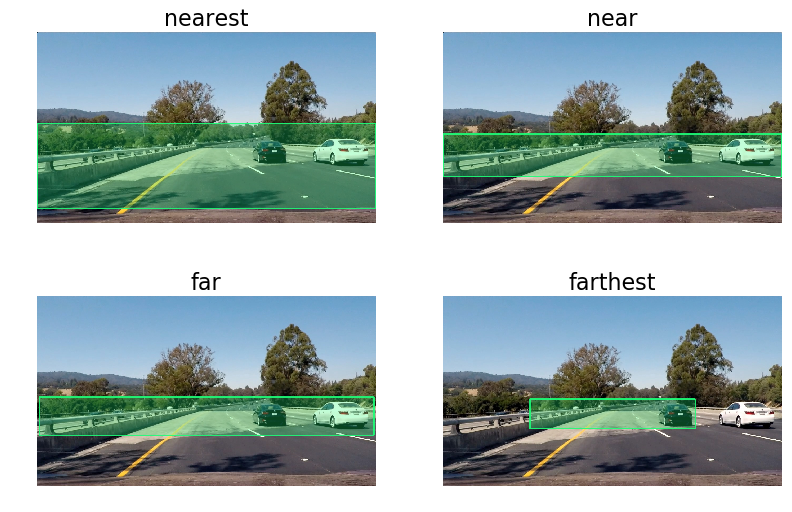

In [198]:
preview = import_image('./test_images/test4.jpg')

plt.subplots(2, 2, figsize=(12, 8), dpi=80)
i = 0

for name, area_of_interest in search_areas.items():
    area_of_interest = [(tup[0] * cell_size, tup[1] * cell_size) for tup in area_of_interest]
    i += 1
    plt.subplot(2, 2, i)
    plot_image(quick_rectangle(preview, area_of_interest, filled=True), title=name)

Obtain a grid search object from these parameters, that can then be used to search the input images.

In [199]:
%run car_tracking.py

<Figure size 432x288 with 0 Axes>

In [200]:
searcher = GridSearch(search_windows, search_areas, analyser)

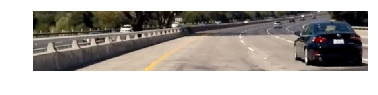

farthest


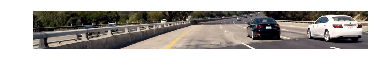

far
Please ensure that your steps in y are set up such that the search fits perfectly into the search area "near".
1.3333333333333333


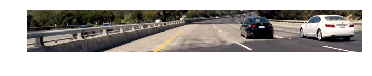

near


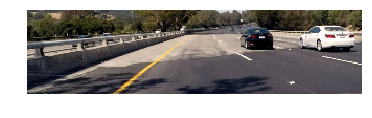

nearest


In [201]:
result = searcher.sliding_search(preview, classifier)

In [202]:
highlighted_img = searcher.highlight_windows(preview, result)

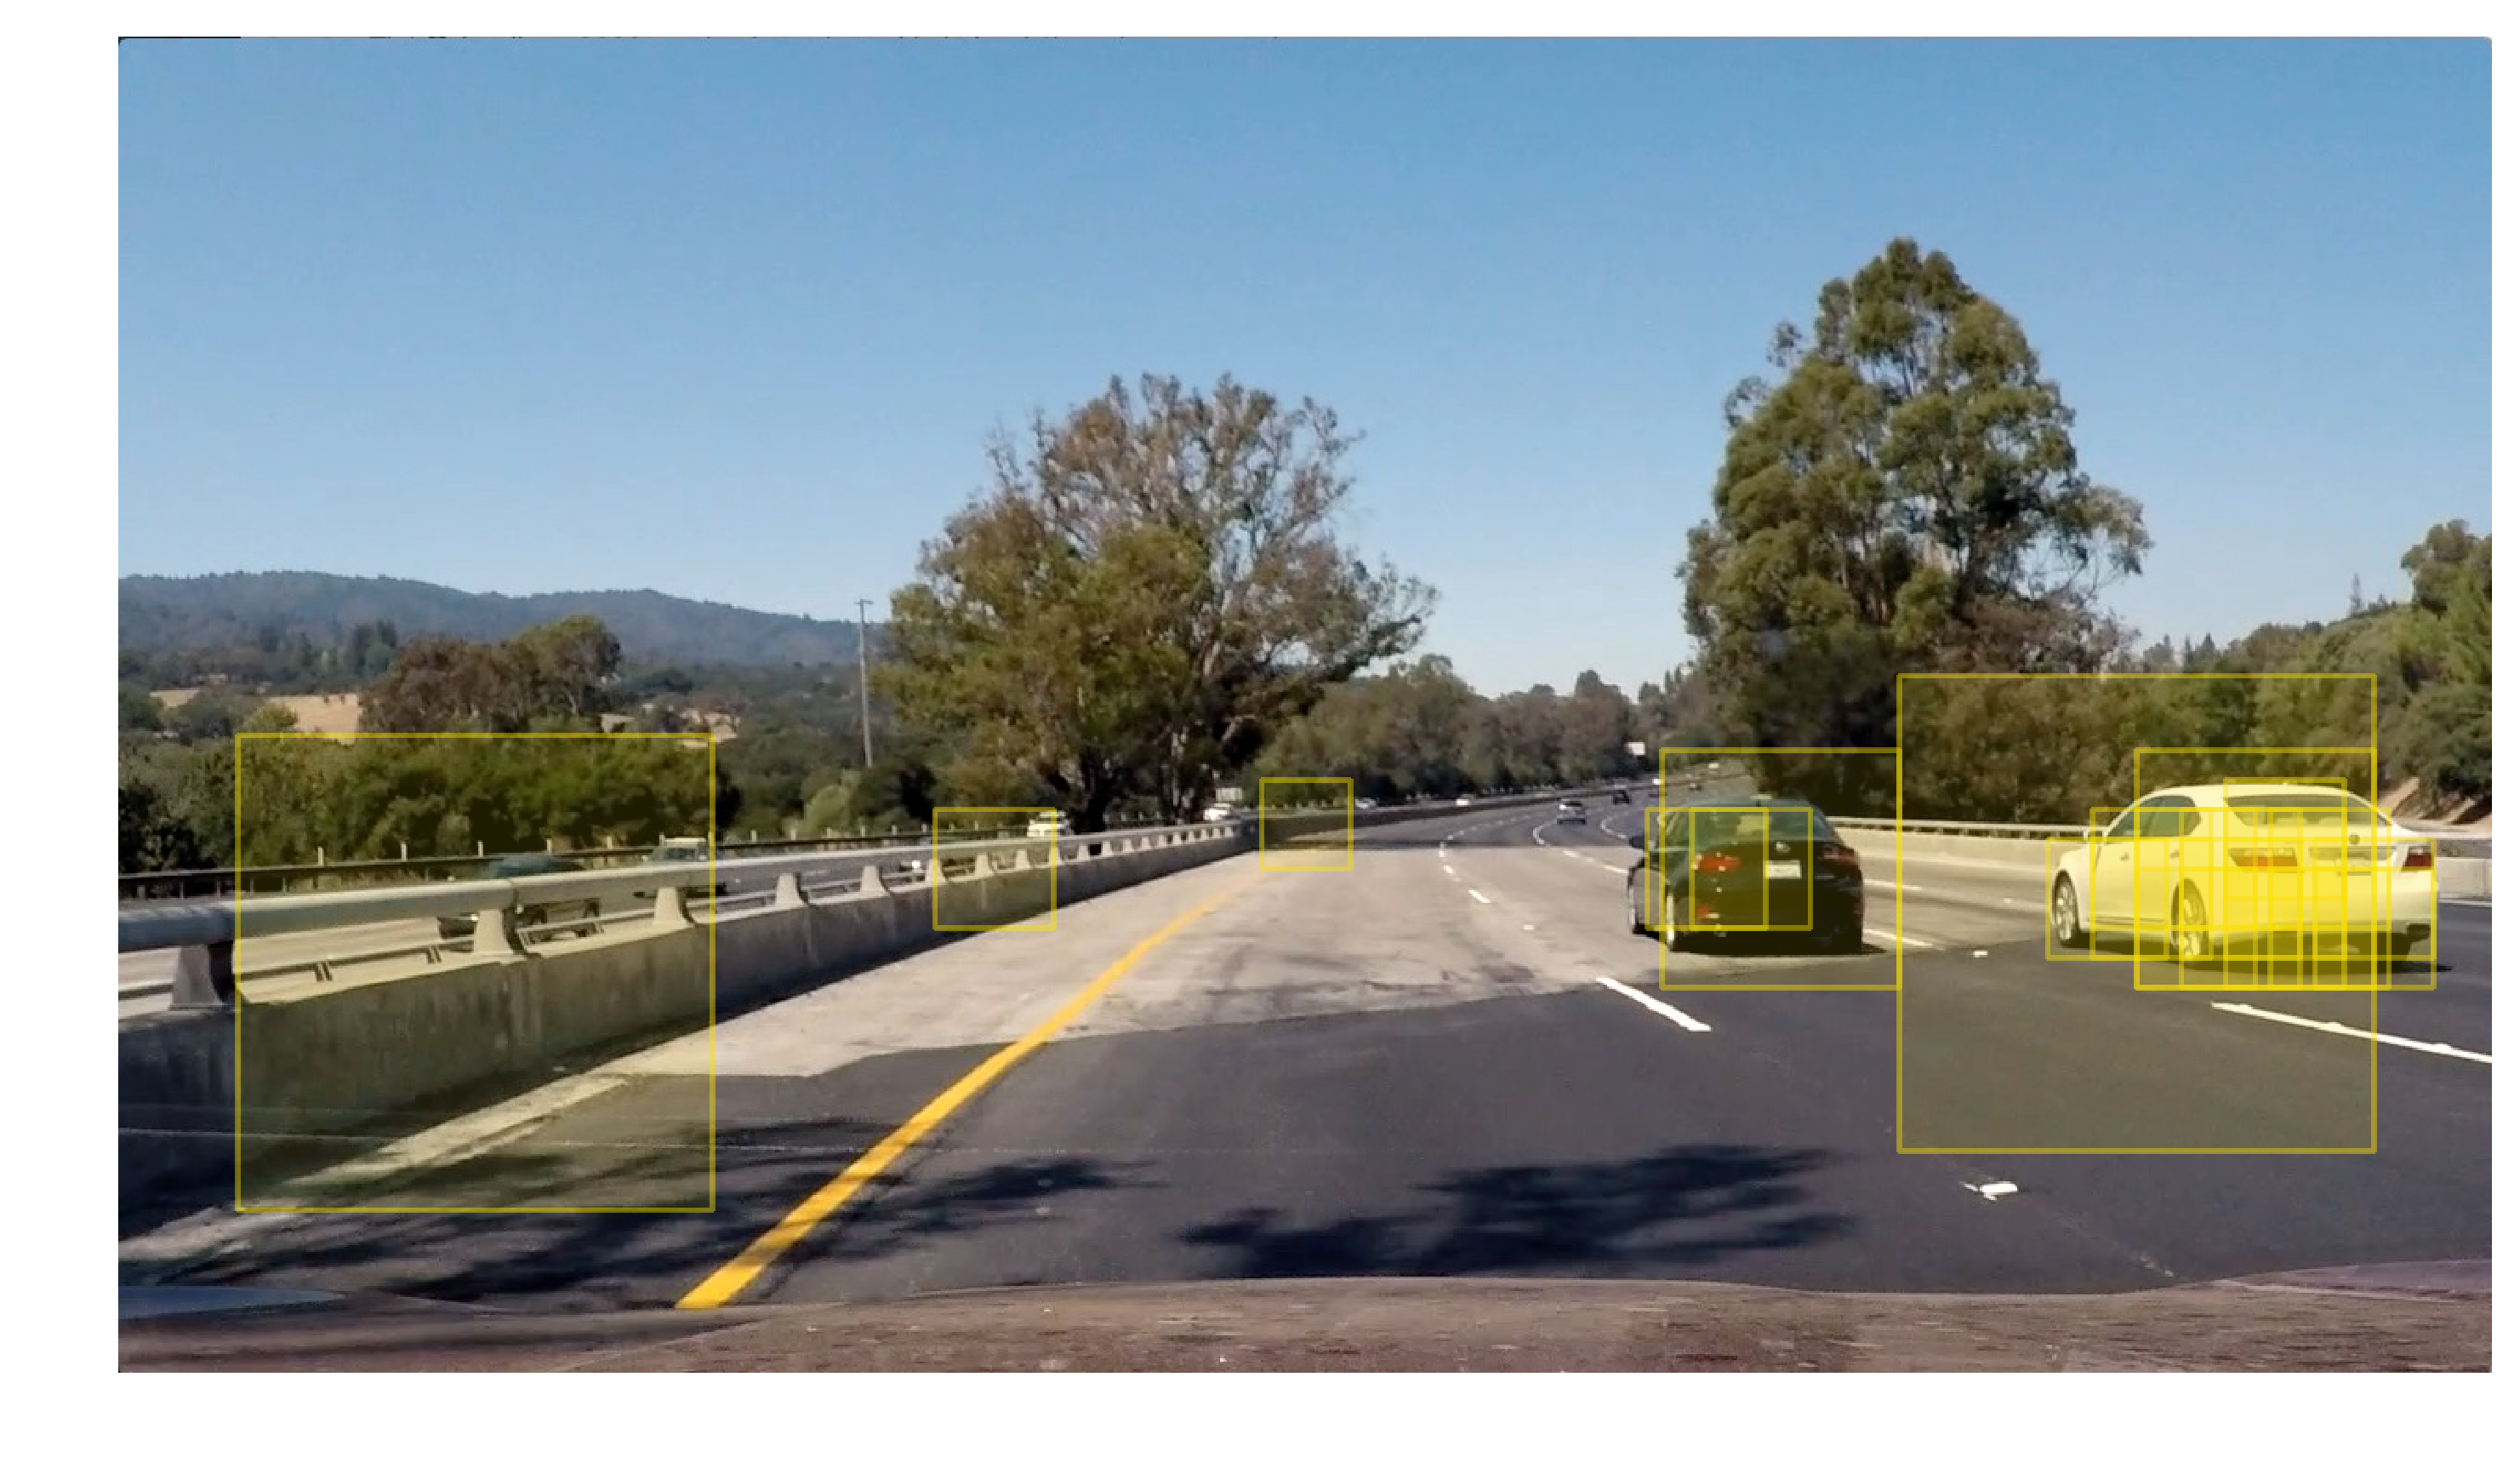

In [203]:
plt.subplots(2, 2, figsize=(12, 8), dpi=300)
plt.subplot(1, 1, 1)
plot_image(highlighted_img)

In [169]:
len(result)

23

In [170]:
result

[{'position': [368, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [384, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [400, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [416, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [496, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [528, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [656, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [672, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [688, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [704, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [720, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [736, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [768, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [784, 408], 'label': 'vehicles', 'window': 'farthest'},
 {'position': [800, 

In the grid searcher use an image frame object that resizes the area of interest and then computes the features, for higher efficiency.

Run the grid searcher on the test images and write the output to the output file

# Processing Video

## Filtering False Positives and Duplicate Matches